In [31]:
import os
import numpy as np
import pandas as pd
import gc

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn import decomposition, preprocessing

from functions import *
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# debug
debug = False
if not debug:
    num_rows = None
else:
    num_rows = 10000
    
def str_to_datetime(strg):
    return datetime.strptime(strg, '%Y-%m-%d %H:%M:%S')
    

# Présentation du jeu de données

**Ce diagramme présente les relations entre les données:**

![image](https://i.imgur.com/HRhd2Y0.png)

L'objectif est de segmenter les clients. Cependant, la base de donnée "customers" contient non pas une ligne par client mais une ligne par commande. On va donc créer notre propre dataframe a partir du jeu de données fourni.

# Analyse exploratoire & Feature engineering

On traite d'abord le fichier client qui associe les IDs client uniques et non uniques. On génère une colonne "nombre de commandes", et une table d'association pour les IDs.

In [32]:
app_customers = pd.read_csv('./data/olist_customers_dataset.csv', nrows=num_rows)
app_aggs = {'customer_id': ['count']}
app = app_customers.groupby('customer_unique_id').agg({**app_aggs})
app.columns = pd.Index(["orders_count"])

# make hash table: customers ids => customer unique ids
cid_to_ucid = pd.DataFrame(data=app_customers[['customer_id', 'customer_unique_id']])
cid_to_ucid = cid_to_ucid.set_index('customer_id')



On traite le fichier des commandes. On ne conserve que les commandes délivrées avec succès (les autres représentant des cas particulier et non des tendances de consommation). Les variables extraites sont le temps de livraison, le delai de paiement, et l'erreur de prediction pour la date de livraison. On génère également une table d'association entre l'ID des commandes et l'ID unique des clients. 

In [33]:
# (+ estimation_error)
app_orders = pd.read_csv('./data/olist_orders_dataset.csv', nrows=num_rows)
app_orders = app_orders.join(cid_to_ucid, how='left', on='customer_id')
# only keep delivered orders with non NaN timestamps
app_orders = app_orders[app_orders["order_status"]=="delivered"]
app_orders = app_orders[app_orders["order_delivered_customer_date"].isnull()==False]
app_orders = app_orders[app_orders["order_approved_at"].isnull()==False]
app_orders = app_orders[app_orders["order_purchase_timestamp"].isnull()==False]
# convert timestamps to datetime
app_orders["order_delivered_customer_date"] = app_orders["order_delivered_customer_date"].apply(str_to_datetime)
app_orders["order_approved_at"] = app_orders["order_approved_at"].apply(str_to_datetime)
app_orders["order_purchase_timestamp"] = app_orders["order_purchase_timestamp"].apply(str_to_datetime)
# create new features
app_orders["shipping_delay"] = app_orders["order_delivered_customer_date"] - app_orders["order_approved_at"]
app_orders["payment_delay"] = app_orders["order_approved_at"] - app_orders["order_purchase_timestamp"]
# convert new features to float
app_orders["shipping_delay"] = app_orders["shipping_delay"].apply(lambda x: x.total_seconds() / 86400) # days
app_orders["payment_delay"] = app_orders["payment_delay"].apply(lambda x: x.total_seconds() / 60) # minutes
# add aggregation to main dataframe
orders_aggs = {
    'shipping_delay': ['mean'],
    'payment_delay': ['mean'],
}
orders = app_orders.groupby('customer_unique_id').agg({**orders_aggs})
orders.columns = pd.Index([e[0] + "_" + e[1] for e in orders.columns.tolist()])
app = app.join(orders, how='left', on='customer_unique_id')
app = app.dropna()

# make hash table: order ids => customer unique ids
oid_to_cuid = pd.DataFrame(data=app_orders[['order_id', 'customer_unique_id']])
oid_to_cuid = oid_to_cuid.set_index('order_id')

On traite le fichier des notes et commentaires pour les commandes délivrées avec succès. On extrait les statistiques associées aux notes, la présence ou non de commentaire et le délai de leur publication.

In [34]:
app_reviews = pd.read_csv('./data/olist_order_reviews_dataset.csv', nrows=num_rows)
app_reviews = app_reviews.join(oid_to_cuid, how='left', on='order_id')
# only keep reviews corresponding to existing orders
app_reviews = app_reviews[app_reviews["order_id"].isin(app_orders["order_id"])]
# convert timestamps to datetime
app_reviews["review_creation_date"] = app_reviews["review_creation_date"].apply(str_to_datetime)
app_reviews["review_answer_timestamp"] = app_reviews["review_answer_timestamp"].apply(str_to_datetime)
# create new features
app_reviews['customer_left_message'] = 1 - app_reviews['review_comment_message'].isnull()
app_reviews['review_delay'] = app_reviews["review_answer_timestamp"] - app_reviews["review_creation_date"]
# convert to float
app_reviews["review_delay"] = app_reviews["review_delay"].apply(lambda x: x.total_seconds() / 86400) # days
# add aggregation to main dataframe
reviews_aggs = {
    'review_score': ['min', 'max', 'mean', 'count'],
    'customer_left_message': ['mean'],
    'review_delay': ['mean']
}
reviews = app_reviews.groupby('customer_unique_id').agg({**reviews_aggs})
reviews.columns = pd.Index([e[0] + "_" + e[1] for e in reviews.columns.tolist()])
app = app.join(reviews, how='left', on='customer_unique_id')

app.head()

,orders_count,shipping_delay_mean,payment_delay_mean,review_score_min,review_score_max,review_score_mean,review_score_count,customer_left_message_mean,review_delay_mean
customer_unique_id,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,6.400914,14.850000,5,5,5.0,1,1.0,4.572778
0000b849f77a49e4a4ce2b2a4ca5be3f,1,2.984005,434.283333,4,4,4.0,1,0.0,0.937095
0000f46a3911fa3c0805444483337064,1,25.731759,0.000000,3,3,3.0,1,0.0,1.055370
0000f6ccb0745a6a4b88665a16c9f078,1,20.023472,19.600000,4,4,4.0,1,1.0,1.012396
0004aac84e0df4da2b147fca70cf8255,1,13.126435,21.166667,5,5,5.0,1,0.0,4.937211


In [35]:
# cleaning
del app_customers, app_orders, app_reviews, orders, reviews, cid_to_ucid, oid_to_cuid
gc.collect()

15

# Réduction de dimension

### ACP

In [36]:
def make_acp(list_of_cols):
    # choix du nombre de composantes à calculer
    n_comp = len(list_of_cols)
    # selection des colonnes à prendre en compte dans l'ACP
    data_pca = app[list_of_cols]
    X = data_pca.values
    features = data_pca.columns
    # affichage de la matrice de corrélation
    d = pd.DataFrame(data=app, columns=list_of_cols)
    corr = d.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.8, center=0,
    square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()
    # Centrage et Réduction
    std_scale = preprocessing.StandardScaler().fit(X)
    X_scaled = std_scale.transform(X)
    # Calcul des composantes principales
    pca = decomposition.PCA(n_components=n_comp)
    pca.fit(X_scaled)
    # Eboulis des valeurs propres
    display_scree_plot(pca)
    # Cercle des corrélations
    pcs = pca.components_
    display_circles(pcs, n_comp, pca, [(0,1)],
                    labels = np.array(features))
    
    plt.show()
    
    return pcs

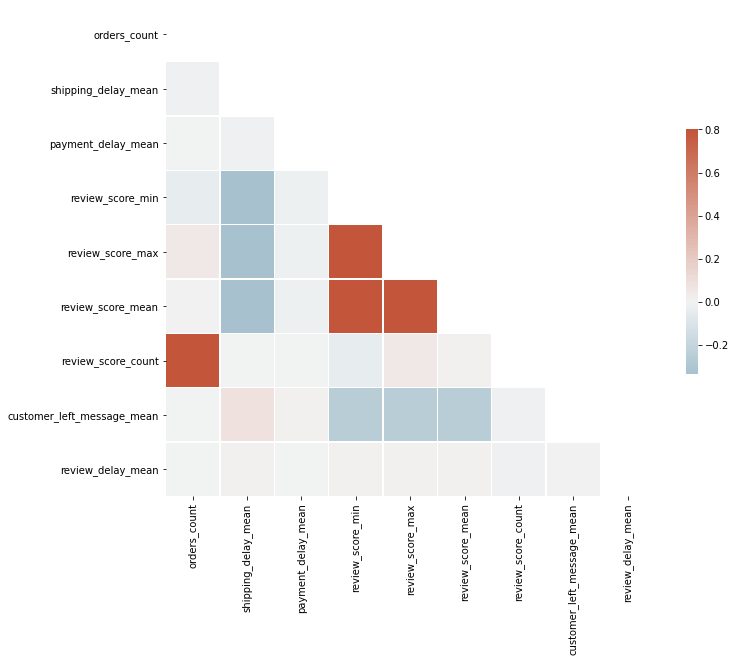

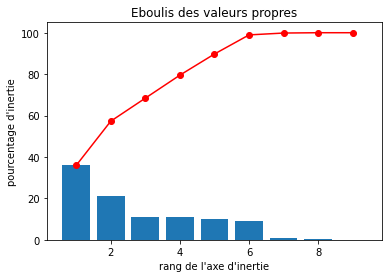

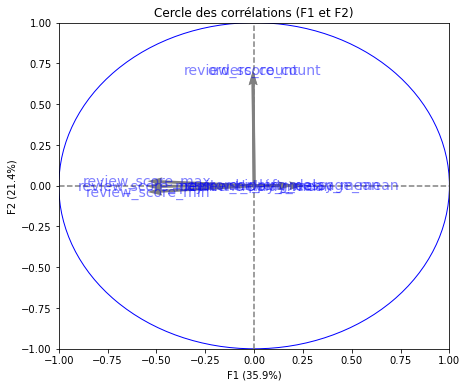

In [37]:
comps = make_acp(app.columns.tolist())

In [38]:
print(comps)

[[-5.47157220e-03  2.54292995e-01  1.10350673e-02 -5.45538892e-01
  -5.45940031e-01 -5.48234545e-01 -6.53128465e-03  1.97232370e-01
  -3.97230690e-03]
 [ 7.06275019e-01  6.15385235e-04 -3.33921744e-03 -3.89524953e-02
   2.81782497e-02 -4.14352318e-03  7.06262670e-01  1.00710328e-03
  -5.25515381e-03]
 [-6.55678248e-04 -1.31258277e-01  8.42042824e-01 -7.75473468e-03
  -8.51120412e-03 -8.17661719e-03  6.74720343e-04  4.38916292e-02
  -5.21160583e-01]
 [ 4.36885227e-03 -4.55621902e-03  5.23040591e-01  7.37906559e-03
   7.07680887e-03  7.26684377e-03  4.52599990e-03  5.42079983e-02
   8.50454210e-01]
 [-2.99219754e-03  3.67367069e-01  1.02855296e-01 -5.25073931e-02
  -5.33078207e-02 -5.31015824e-02  3.37967043e-03 -9.19794326e-01
  -1.31120395e-03]
 [-6.03994036e-04  8.84937006e-01  8.17149936e-02  1.77862610e-01
   1.77391749e-01  1.78389938e-01  2.99462056e-03  3.31963999e-01
  -7.12307247e-02]
 [ 7.07188828e-01  3.59120243e-03  1.51109510e-03  1.74175855e-03
  -2.27752571e-03  2.3770532

### TSNE

In [39]:
# app_embedded = TSNE(n_components=2).fit_transform(app)

# Classification non supervisée

In [40]:
kmeans = KMeans(n_clusters = 6).fit(app)
kmeans.labels_
kmeans.cluster_centers_

array([[1.03441631e+00, 1.21157737e+01, 3.98776245e+01, 4.13744118e+00,
        4.16072896e+00, 4.14925343e+00, 1.03753828e+00, 4.07820848e-01,
        3.13412310e+00],
       [1.03827073e+00, 1.25549266e+01, 2.28842040e+03, 4.11138672e+00,
        4.13335696e+00, 4.12235806e+00, 1.04429483e+00, 4.22897472e-01,
        3.20743797e+00],
       [1.04358664e+00, 1.22271988e+01, 1.17897384e+03, 4.11509152e+00,
        4.14194146e+00, 4.12878763e+00, 1.04821594e+00, 4.12884885e-01,
        3.23920881e+00],
       [1.02256117e+00, 1.17187548e+01, 4.25774041e+03, 4.05338418e+00,
        4.06482364e+00, 4.05898740e+00, 1.02446775e+00, 4.18462027e-01,
        2.96598026e+00],
       [1.01997147e+00, 9.73239608e+00, 7.04897563e+03, 4.12268188e+00,
        4.13124108e+00, 4.12719924e+00, 1.01997147e+00, 3.88017118e-01,
        3.36487004e+00],
       [1.00000000e+00, 5.83509322e+00, 1.86954568e+04, 3.59459459e+00,
        3.59459459e+00, 3.59459459e+00, 1.00000000e+00, 6.21621622e-01,
        2.8

# Résultats